In [1]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 10429, done.
remote: Total 10429 (delta 0), reused 0 (delta 0), pack-reused 10429
Receiving objects: 100% (10429/10429), 10.62 MiB | 3.62 MiB/s, done.
Resolving deltas: 100% (7203/7203), done.


In [1]:
!which pip

/home/anish/.virtualenvs/py36_PED/bin/pip


In [7]:
!pip install -r ./yolov5/requirements.txt

     |████████████████████████████████| 60.4 MB 3.2 MB/s            
     |████████████████████████████████| 603 kB 4.7 MB/s            
     |████████████████████████████████| 63 kB 2.6 MB/s            
     |████████████████████████████████| 881.9 MB 2.7 kB/s             
     |████████████████████████████████| 23.3 MB 3.7 MB/s            
     |████████████████████████████████| 76 kB 4.0 MB/s            
     |████████████████████████████████| 5.8 MB 3.8 MB/s            
     |████████████████████████████████| 9.5 MB 3.2 MB/s            �             | 5.5 MB 3.7 MB/s eta 0:00:02
     |████████████████████████████████| 292 kB 5.1 MB/s            
     |████████████████████████████████| 138 kB 5.4 MB/s            
     |████████████████████████████████| 61 kB 4.9 MB/s            
     |████████████████████████████████| 149 kB 5.6 MB/s            
     |████████████████████████████████| 4.9 MB 3.3 MB/s            
     |████████████████████████████████| 4.1 MB 5.4 MB/s            
   

In [2]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
random.seed(108)

In [27]:
# Function to get the data from XML Annotation - PASCOL VAC -> Yolo_v5 format
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
            # Debug - print(f"{info_dict['filename']}, size:{info_dict['image_size']}")
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [41]:
print(extract_info_from_xml('./PPE_Medical/dataset/train/jeks.xml'))

{'bboxes': [{'class': 'Mask', 'xmin': 347, 'ymin': 193, 'xmax': 402, 'ymax': 244}, {'class': 'Face_Shield', 'xmin': 323, 'ymin': 144, 'xmax': 423, 'ymax': 272}, {'class': 'Gloves', 'xmin': 211, 'ymin': 482, 'xmax': 254, 'ymax': 548}, {'class': 'Gloves', 'xmin': 549, 'ymin': 536, 'xmax': 591, 'ymax': 600}, {'class': 'Coverall', 'xmin': 198, 'ymin': 115, 'xmax': 598, 'ymax': 930}], 'filename': 'jeks.jpg', 'image_size': (900, 945, 3)}


In [64]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"Coverall": 0,
                           "Face_Shield": 1,
                           "Gloves": 2,
                           "Goggles": 3,
                           "Mask":4}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict, outputPath):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"] 
        #print(f'w:{image_w}, h:{image_h}, c:{image_c}')
        #print(info_dict["filename"])
        b_center_x /= image_w
        b_center_y /= image_h
        b_width    /= image_w 
        b_height   /= image_h 
     
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    if info_dict["filename"].split('.')[1] =='jpg':
        save_file_name = os.path.join(outputPath, info_dict["filename"].replace("jpg", "txt"))
    elif info_dict["filename"].split('.')[1] =='jpeg':
         save_file_name = os.path.join(outputPath, info_dict["filename"].replace("jpeg", "txt"))
    else:
        save_file_name = os.path.join(outputPath, info_dict["filename"].replace("png", "txt"))
    #print(save_file_name)
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [66]:
# Convert XML to Yolo format
# Get the annotations

InputPath='./PPE_Medical/dataset/test/'
OutputPath='./PPE_Medical/YoloFormat/test/'

annotations = glob(InputPath+'*.xml')
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict,OutputPath)

annotations = glob(OutputPath+'*.txt')

100%|██████████| 50/50 [00:00<00:00, 2808.26it/s]


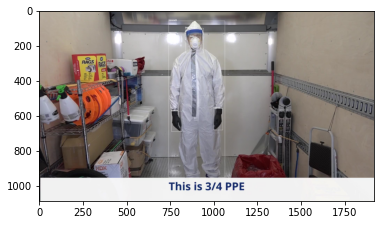

In [70]:
# Testing the annotations

random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

    
# Test

annotations = glob('/media/Evo_plus_1TB/PED_for_FRs/PPE_Medical/YoloFormat/labels/train/'+'*.txt')
# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("labels", "images").replace("txt", "jpg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [72]:
# Setup dataset for train, val and test
# =====================================# 
# Read images and annotations

rootPath='/media/Evo_plus_1TB/PED_for_FRs/PPE_Medical/YoloFormat/'

images = [os.path.join(f'{rootPath}/images/train/', x) for x in os.listdir(f'{rootPath}/images/train/')]
annotations = [os.path.join(f'{rootPath}/labels/train/', x) for x in os.listdir(f'{rootPath}/labels/train/') if x[-3:] == "txt"]

images.sort()
annotations.sort()
# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
#val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [55]:
!mkdir ./test_dataset_traffic_signs/images/train 
!mkdir ./test_dataset_traffic_signs/images/val 
!mkdir ./test_dataset_traffic_signs/images/test 
!mkdir ./test_dataset_traffic_signs/lables/train 
!mkdir ./test_dataset_traffic_signs/lables/val 
!mkdir ./test_dataset_traffic_signs/lables/test

In [73]:
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            #assert False


# Move the splits into their folders
move_files_to_folder(train_images, '/media/Evo_plus_1TB/PED_for_FRs/PPE_Medical/YoloFormat/temp/train/')
move_files_to_folder(val_images, '/media/Evo_plus_1TB/PED_for_FRs/PPE_Medical/YoloFormat/temp/val/')
move_files_to_folder(train_annotations, '/media/Evo_plus_1TB/PED_for_FRs/PPE_Medical/YoloFormat/temp/train/')
move_files_to_folder(val_annotations, '/media/Evo_plus_1TB/PED_for_FRs/PPE_Medical/YoloFormat/temp/val/')


In [76]:
!ls /media/Evo_plus_1TB/PED_for_FRs/yolov5_for_ppe_medical/yolov5/data

Argoverse.yaml	      hyps		scripts        xView.yaml
coco128.yaml	      images		SKU-110K.yaml
coco.yaml	      Objects365.yaml	VisDrone.yaml
GlobalWheat2020.yaml  PPE_medical.yaml	VOC.yaml


In [77]:
!cat /media/Evo_plus_1TB/PED_for_FRs/yolov5_for_ppe_medical/yolov5/data/PPE_medical.yaml

train: /media/Evo_plus_1TB/PED_for_FRs/PPE_Medical/YoloFormat/images/train/ 
val:  /media/Evo_plus_1TB/PED_for_FRs/PPE_Medical/YoloFormat/images/val/
test: /media/Evo_plus_1TB/PED_for_FRs/PPE_Medical/YoloFormat/images/test/

# number of classes
nc: 5

# class names
names: ["Coverall","Face_shield", "Gloves","Goggles","Mask"]




In [78]:
!python ./yolov5_for_ppe_medical/yolov5/train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 32 --epochs 100 --data PPE_medical.yaml --weights yolov5s.pt --workers 24 --name yolo_PPE_medical

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=PPE_medical.yaml, hyp=hyp.scratch.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=yolov5_for_ppe_medical/yolov5/runs/train, name=yolo_PPE_medical, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (16/16), done.
remote: Total 23 (delta 16), reused 16 (delta 16), pack-reused 7
Unpacking objects: 100% (23/23), 30.28 KiB | 1.59 MiB/s, done.
From https://github.com/ultralytics/yolov5
   a2f4a17..5402753  master     -> origin/master
   d5f5369..20743f2  classifier -> origin/classifier
github: ⚠️ YOLOv5 is out of


     Epoch   gpu_mem       box       obj       cls    labels  img_size
      7/99     6.94G   0.07828   0.06126   0.03951        27       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         74        351      0.476      0.333      0.217     0.0559

     Epoch   gpu_mem       box       obj       cls    labels  img_size
      8/99     6.94G   0.07577   0.06043   0.03809        41       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         74        351      0.496      0.301      0.231     0.0552

     Epoch   gpu_mem       box       obj       cls    labels  img_size
      9/99     6.94G    0.0703   0.05552   0.03631        36       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         74        351      0.172      0.373      0.214     0.0546

     Epoch   gpu_mem       box      

               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         74        351      0.552      0.724      0.705      0.332

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     33/99     6.94G   0.05217   0.03892   0.01506        31       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         74        351      0.452      0.687      0.579      0.272

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     34/99     6.94G   0.05211   0.03837   0.01466        39       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         74        351      0.579      0.711      0.674      0.315

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     35/99     6.94G   0.05277   0.03976   0.01553        52       640: 100%|███
               Class     Images     L


     Epoch   gpu_mem       box       obj       cls    labels  img_size
     58/99     6.94G   0.04634   0.03297   0.01073        45       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         74        351      0.788      0.758      0.808      0.446

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     59/99     6.94G   0.04693   0.03223   0.01087        24       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         74        351      0.888      0.809      0.867       0.49

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     60/99     6.94G   0.04582   0.03306   0.01082        24       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         74        351      0.912      0.788      0.856      0.494

     Epoch   gpu_mem       box      

               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         74        351      0.929      0.819      0.878      0.566

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     84/99     6.94G   0.03484   0.02972  0.008155        29       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         74        351      0.913      0.829      0.878       0.55

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     85/99     6.94G    0.0345   0.03052  0.008129        36       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         74        351       0.91      0.808      0.874      0.558

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     86/99     6.94G   0.03447   0.02811  0.008659        18       640: 100%|███
               Class     Images     L

In [80]:
# Testing
!python ./yolov5_for_ppe_medical/yolov5/detect.py --source ./PPE_Medical/YoloFormat/images/test --weights ./yolov5_for_ppe_medical/yolov5/runs/train/yolo_PPE_medical/weights/best.pt --conf 0.25 --name yolo_PPE_medical

detect: weights=['./yolov5_for_ppe_medical/yolov5/runs/train/yolo_PPE_medical/weights/best.pt'], source=./PPE_Medical/YoloFormat/images/test, data=yolov5_for_ppe_medical/yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5_for_ppe_medical/yolov5/runs/detect, name=yolo_PPE_medical, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-172-gfb83929 torch 1.10.1+cu102 CUDA:0 (GeForce RTX 2080 Ti, 11011MiB)

Fusing layers... 
Model Summary: 213 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
image 1/50 /media/Evo_plus_1TB/PED_for_FRs/PPE_Medical/YoloFormat/images/test/3y46u.jpg: 640x384 1 Coverall, 1 Mask, Done. (0.004s)
image 2/50 /media/Evo_plus_1TB/PED_for_FRs/PPE_Medical/YoloFormat/images/test/arht.jpg: 608x640 

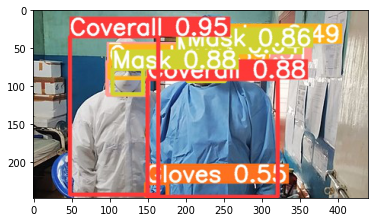

In [84]:
# Plot the inferenced images
detections_dir = "./yolov5_for_ppe_medical/yolov5/runs/detect/yolo_PPE_medical/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

In [87]:
!python ./yolov5_for_ppe_medical/yolov5/val.py --weights ./yolov5_for_ppe_medical/yolov5/runs/train/yolo_PPE_medical/weights/best.pt --data PPE_medical.yaml --img 640

val: data=/media/Evo_plus_1TB/PED_for_FRs/yolov5_for_ppe_medical/yolov5/data/PPE_medical.yaml, weights=['./yolov5_for_ppe_medical/yolov5/runs/train/yolo_PPE_medical/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5_for_ppe_medical/yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-172-gfb83929 torch 1.10.1+cu102 CUDA:0 (GeForce RTX 2080 Ti, 11011MiB)

Fusing layers... 
Model Summary: 213 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/media/Evo_plus_1TB/PED_for_FRs/PPE_Medical/YoloFormat/labels/tes
val: New cache created: /media/Evo_plus_1TB/PED_for_FRs/PPE_Medical/YoloFormat/labels/test.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         50        362      0.771      0.709      0.733    